<a href="https://colab.research.google.com/github/Arash-Razi/ML_Dr_Aliyari_Course_2025/blob/main/MiniP4/ML2025_MiniP4_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imprt Libraries

In [ ]:
import numpy as np
import random
import time
from abc import ABC, abstractmethod
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Decision making Approches:
*   **Q-Learning**
*   **DQN**





### Abstract class for Decision making approches

In [ ]:
class DecisionMaking(ABC):
    @abstractmethod
    def choose_action(self, state, epsilon, valid_actions):
        pass

    @abstractmethod
    def update(self, state, action, reward, next_state, alpha, gamma):
        pass

### **Q-Learning** Method Implementation

In [ ]:
class QLearningDecision(DecisionMaking):
    def __init__(self, actions):
        self.q_table = {}
        self.actions = actions

    def choose_action(self, state, epsilon, valid_actions):
        state_tuple = tuple(state)
        if state_tuple not in self.q_table:
            self.q_table[state_tuple] = np.zeros(len(self.actions))
        q_values = self.q_table[state_tuple].copy()
        for i in range(len(self.actions)):
            if i not in valid_actions:
                q_values[i] = -np.inf
        if np.random.rand() < epsilon or all(v == -np.inf for v in q_values):
            return np.random.choice(valid_actions)
        return np.argmax(q_values)

    def update(self, state, action, reward, next_state, alpha, gamma):
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        if next_state_tuple not in self.q_table:
            self.q_table[next_state_tuple] = np.zeros(len(self.actions))
        self.q_table[state_tuple][action] += alpha * (reward + gamma * np.max(self.q_table[next_state_tuple]) - self.q_table[state_tuple][action])

### **DQN** Method implemetation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from abc import ABC

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNDecision(DecisionMaking):
    def __init__(self, state_dim, action_dim, grid_size,
                 lr=1e-4, gamma=0.95, tau=0.01, memory_size=100_000, batch_size=64):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.grid_size = grid_size

        self.policy_net = DQNetwork(state_dim, action_dim).to(DEVICE)
        self.target_net = DQNetwork(state_dim, action_dim).to(DEVICE)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        self.memory = deque(maxlen=memory_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.min_memory = 1000

    def normalize_state(self, state):
        s = list(state)
        s[0] /= (self.grid_size - 1)
        s[1] /= (self.grid_size - 1)
        s[2] /= (self.grid_size - 1)
        s[3] /= (self.grid_size - 1)
        return torch.tensor(s, dtype=torch.float32, device=DEVICE)

    def choose_action(self, state, epsilon, valid_actions):
        if np.random.rand() < epsilon:
            return random.choice(valid_actions)
        with torch.no_grad():
            state_tensor = self.normalize_state(state).unsqueeze(0)
            q_values = self.policy_net(state_tensor).squeeze().cpu().numpy()
            q_values = [q if i in valid_actions else -np.inf for i, q in enumerate(q_values)]
            return int(np.argmax(q_values))

    def update(self, state, action, reward, next_state, alpha, gamma):
        done = reward >= 100 or reward <= -1000
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) < max(self.min_memory, self.batch_size):
            return

        batch = random.sample(self.memory, self.batch_size)

        states = torch.stack([self.normalize_state(s) for (s, _, _, _, _) in batch])
        actions = torch.tensor([a for (_, a, _, _, _) in batch], device=DEVICE)
        rewards = torch.tensor([r for (_, _, r, _, _) in batch], dtype=torch.float32, device=DEVICE)
        next_states = torch.stack([self.normalize_state(ns) for (_, _, _, ns, _) in batch])
        dones = torch.tensor([float(d) for (_, _, _, _, d) in batch], device=DEVICE)

        q_vals = self.policy_net(states)
        q_next = self.target_net(next_states).detach()

        targets = q_vals.clone()
        targets[range(self.batch_size), actions] = rewards + self.gamma * torch.max(q_next, dim=1).values * (1 - dones)

        loss = self.criterion(q_vals, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        with torch.no_grad():
            for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                target_param.data.copy_(self.tau * policy_param.data + (1 - self.tau) * target_param.data)


## **Game Objects**

*   **Agent**
*   **Wumpus**
*   **enviroment**



### **Agent**

In [ ]:
class Agent:
    def __init__(self, start_pos, decision_maker, grid_size):
        self.start_pos = start_pos
        self.pos = start_pos
        self.has_arrow = True
        self.decision_maker = decision_maker
        self.grid_size = grid_size


    def reset(self):
        self.pos = self.start_pos
        self.has_arrow = True

    def get_state(self, wumpus_pos, wumpus_alive):
        return self.pos + wumpus_pos + (int(wumpus_alive), int(self.has_arrow))



    def choose_action(self, state, epsilon, valid_actions):
        filtered_actions = [a for a in valid_actions if self.has_arrow or a < 4]
        return self.decision_maker.choose_action(state, epsilon, filtered_actions)

    def update(self, state, action, reward, next_state, alpha, gamma):
        self.decision_maker.update(state, action, reward, next_state, alpha, gamma)

### **Wumpus**

In [ ]:
class Wumpus:
    def __init__(self, start_pos):
        self.start_pos = start_pos
        self.pos = start_pos
        self.alive = True

    def reset(self):
        self.pos = self.start_pos
        self.alive = True

    def move(self, env):
        if not self.alive:
            return
        possible = []
        for a in range(4):
            new_pos = env.move(self.pos, a)
            if new_pos != self.pos:
                possible.append(new_pos)
        if possible:
            self.pos = possible[np.random.randint(len(possible))]

### **Enviroment**

In [ ]:
class Environment:
    def __init__(self, grid_size, pits, gold_pos):
        self.grid_size = grid_size
        self.pits = pits
        self.gold_pos = gold_pos

    def move(self, pos, action):
        x, y = pos
        if action == 0 and x > 0: x -= 1
        elif action == 1 and x < self.grid_size-1: x += 1
        elif action == 2 and y > 0: y -= 1
        elif action == 3 and y < self.grid_size-1: y += 1
        return (x, y)

    def valid_actions(self, pos, has_arrow):
        """
        Returns a list of valid actions based on agent position and whether it has an arrow.
        """
        x, y = pos
        valid = []
        if x > 0: valid.append(0)         # up
        if x < self.grid_size-1: valid.append(1)   # down
        if y > 0: valid.append(2)         # left
        if y < self.grid_size-1: valid.append(3)   # right
        if has_arrow:
            valid += [4, 5, 6, 7]         # shooting in directions
        return valid



    def reward(self, agent_pos, wumpus):
        """
        Calculates reward based on agent position and Wumpus state.
        """
        if agent_pos == self.gold_pos:
            return 100, True, "agent got the gold"
        elif agent_pos in self.pits:
            return -1000, True, "agent fell into a pit"
        elif agent_pos == wumpus.pos and wumpus.alive:
            return -1000, True, "agent got eaten by Wumpus"
        elif not wumpus.alive:
            return 50, False, "Wumpus killed"
        else:
            return -1, False, None



    def display(self, agent, wumpus, arrow_shot, message):
        grid = np.full((self.grid_size, self.grid_size), '⬜', dtype=object)
        for pit in self.pits:
            grid[pit] = '🕳️'
        if wumpus.alive:
            grid[wumpus.pos] = '👹'
        grid[self.gold_pos] = '💰'
        if arrow_shot:
            grid[arrow_shot] = '🏹'
        grid[agent.pos] = '🤖'
        for row in grid:
            print(' '.join(row))
        if message:
            print(message)
        print()

## **Setting Parameters**

In [ ]:
grid_size = 4
start_pos = (2, 0)
wumpus_start = (2, 2)
gold_pos = (3, 2)
pits = [(1, 3)]
actions = list(range(8))

alpha = 0.1
gamma = 0.9
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
episodes = 5000
max_steps = 75

env = Environment(grid_size, pits, gold_pos)
wumpus = Wumpus(wumpus_start)

### **Agent With Q-Learning Method**

In [ ]:
decision_maker = QLearningDecision(actions=actions)
agent = Agent(start_pos, decision_maker, grid_size)

### **Agent With DQN Method**


In [ ]:
# decision_maker = DQNDecision(state_dim=6, action_dim=8, lr=5e-4, grid_size=grid_size)
# agent = Agent(start_pos, decision_maker, grid_size)

## **Training loop**

In [ ]:
reward_history = []

for ep in range(1, episodes+1):
    agent.reset()
    wumpus.reset()
    done = False
    arrow_shot = None
    result_message = ""

    total_reward = 0

    for step in range(max_steps):
        state = agent.get_state(wumpus.pos, wumpus.alive)
        valid_actions = env.valid_actions(agent.pos, agent.has_arrow)
        action = agent.choose_action(state, epsilon, valid_actions)

        next_pos = env.move(agent.pos, action) if action < 4 else agent.pos
        next_wumpus_alive = wumpus.alive
        next_arrow_used = agent.has_arrow
        arrow_shot = None
        r = -1

        if action >= 4 and agent.has_arrow:
            dir_map = {4:0, 5:1, 6:2, 7:3}
            shoot_dir = dir_map[action]
            temp = agent.pos
            while True:
                temp_next = env.move(temp, shoot_dir)
                if temp_next == temp:
                    break
                if temp_next == wumpus.pos:
                    next_wumpus_alive = False
                    arrow_shot = temp_next
                    break
                temp = temp_next
            next_arrow_used = False

        wumpus.alive = next_wumpus_alive

        reward_val, done, result_message = env.reward(next_pos, wumpus)
        r += reward_val
        total_reward += r

        next_state = agent.get_state(next_pos, next_wumpus_alive)
        agent.update(state, action, r, next_state, alpha, gamma)

        agent.pos = next_pos
        agent.has_arrow = next_arrow_used

        if not done:
            wumpus.move(env)

        if done:
            break

    reward_history.append(total_reward)

    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if ep % 50 == 0:
        clear_output(wait=True)
        env.display(agent, wumpus, arrow_shot, f"Episode {ep} — result: {result_message or 'agent still alive'}")
        time.sleep(0.1)

print("Training completed.")


⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🤖
⬜ ⬜ ⬜ ⬜
⬜ ⬜ 💰 ⬜
Episode 5000 — result: agent fell into a pit

Training completed.


### **Plot Reward diagram during training**

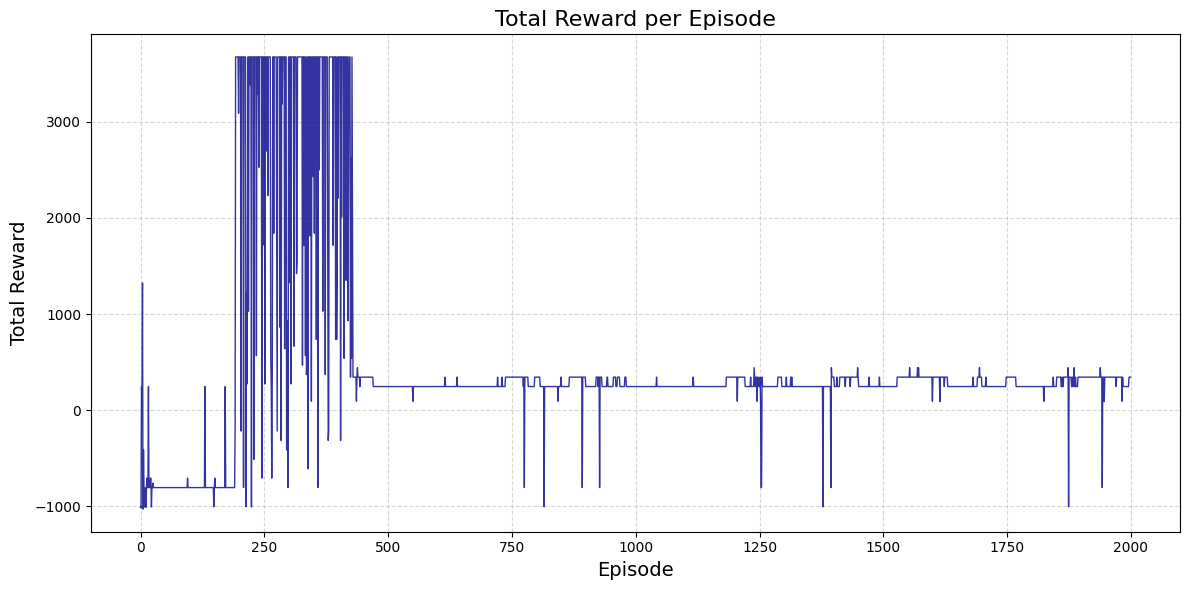

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(reward_history, color='darkblue', linewidth=1, alpha=0.8)

plt.title("Total Reward per Episode", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Total Reward", fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



### **Average Mean in 1000 last episodes**

In [ ]:
r = np.mean(reward_history[-1000:])
print(f'average reward for last 1000 episodes: {r}')

average reward for last 1000 episodes: 337.49


## **Final Episode**

In [ ]:
agent.reset()
wumpus.reset()
done = False
arrow_shot = None

epsilon = 0

for step in range(max_steps):
    state = agent.get_state(wumpus.pos, wumpus.alive)
    valid_actions = env.valid_actions(agent.pos,agent.has_arrow)
    action = agent.choose_action(state, epsilon, valid_actions)

    next_pos = env.move(agent.pos, action) if action < 4 else agent.pos

    if action >= 4 and agent.has_arrow:
        dir_map = {4:0, 5:1, 6:2, 7:3}
        shoot_dir = dir_map[action]
        temp = agent.pos
        while True:
            temp_next = env.move(temp, shoot_dir)
            if temp_next == temp:
                break
            if temp_next == wumpus.pos:
                wumpus.alive = False
                arrow_shot = temp_next
                break
            temp = temp_next
        agent.has_arrow = False

    agent.pos = next_pos

    if wumpus.alive:
        wumpus.move(env)

    _, done, result_message = env.reward(agent.pos, wumpus)

    clear_output(wait=True)
    env.display(agent, wumpus, arrow_shot, f"Final Episode — result: {result_message or 'agent still alive'}")
    time.sleep(0.7)

    if done:
        break

print("Final episode completed.")

⬜ ⬜ ⬜ ⬜
⬜ ⬜ ⬜ 🕳️
⬜ ⬜ 🏹 ⬜
⬜ ⬜ 🤖 ⬜
Final Episode — result: agent got the gold

Final episode completed.
